<a href="https://colab.research.google.com/github/comparativechrono/VariantFold/blob/main/VariantFold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Connect Google Drive and install modules for ColabFold
from google.colab import drive

drive.mount('/content/drive/')

!pip install biopython

Run to check your assigned GPU info (use Runtime -> Change runtime type -> Hardware accelerator -> change to GPU if None is selected)

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Run and Enter your **gene** symbol. You will also get a link to ClinVar for your gene.

In [ ]:
gene_symbol = input("Enter the gene symbol: ")
url = f"http://www.ncbi.nlm.nih.gov/clinvar/?term={gene_symbol}[gene]"
html_link = f'<a href="{url}" target="_blank">{url}</a>'

# Display the hyperlink
from IPython.display import display, HTML
display(HTML(html_link))

Use obtained ClinVar link to filter and download variants using the default download settings as shown below. **Remember, you need 2 separate files**, one with pathogenic variants (rename to *clinvar_result_ptg.txt*) and one with benign variants (rename to *clinvar_result_bng.txt*).

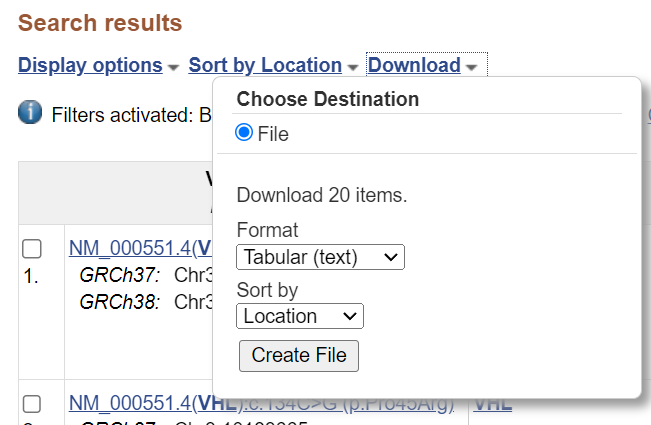

Run to create VariantFold working directory

In [ ]:
import os
import shutil

directory = f"/content/drive/MyDrive/VariantFold_{gene_symbol}"
if not os.path.exists(directory):
      try:
          os.mkdir(directory)
      except Exception as e:
          print(f"Error occurred while creating the directory: {e}")
else:
  print(f"Directory '{directory}' already exists.")
os.chdir(directory)

Upload *clinvar_result_bng.txt* for **BENIGN** variants and *clinvar_result_ptg.txt* for **PATHOGENIC** variants into the created **VariantFold_{gene_symbol}** folder.

Run the following cell to automatocally obtain a protein sequence for your gene or reveal the cell below to enter it manually.  

In [ ]:
from Bio import Entrez, SeqIO
Entrez.email = "your_email@gmail.com"  # Replace with your email address

def get_protein_sequence(accession_number):
    handle = Entrez.efetch(db="protein", id=accession_number, rettype="gb", retmode="text")
    record = SeqIO.read(handle, "genbank")
    handle.close()
    return record.seq

def get_protein_accession_number(gene_symbol):
    search_term = f"{gene_symbol}[Gene] AND human[ORGN] AND srcdb_refseq[Properties]" #seacrh terms can be adjusted see: https://www.ncbi.nlm.nih.gov/books/NBK49540/
    handle = Entrez.esearch(db="protein", term=search_term, retmax=1)
    record = Entrez.read(handle)
    handle.close()
    if "IdList" in record and record["IdList"]:
        return record["IdList"][0]
    else:
        return None

accession_number = get_protein_accession_number(gene_symbol)

if accession_number:
    sequence = get_protein_sequence(accession_number)
    print(f"Amino acid sequence of {gene_symbol} (Accession: {accession_number}):")
    print(sequence)
    print(f"The selected transcript consists of {len(str(sequence))} amino acids.")
else:
    print(f"Protein '{gene_symbol}' not found in Entrez.")

f = open("original_sequence.txt", "w")
f.write(str(sequence))
f.close()


In [ ]:
#@title Enter sequence manually or with accession number DO NOT RUN if used automatic option above

#You can use an accession number for your desired transcript
def get_protein_sequence_manual():
  accession_number = "NP_000537.3" #change for desired transcript id

  handle = Entrez.efetch(db="protein", id=accession_number, rettype="gb", retmode="text")
  record = SeqIO.read(handle, "genbank")
  handle.close()

  return record.seq

# Retrieve protein sequence
manual_protein_sequence = get_protein_sequence_manual()

#Or you can unhash the following line and paste your sequence into a manual_protein_sequence variable
#manual_protein_sequence = "enter your sequence here"
f = open("original_sequence.txt", "w")
f.write(str(manual_protein_sequence))
f.close()

### Part I
Run ColabFold to obtain protein structure predctions using the variant information provided above. It will automatically process both benign and pathogenic variants. **The run might take some time.**

### **ColabFold**

In [ ]:
#@title Install dependencies for ColabFold
%%bash -s $use_amber $use_templates $python_version

set -e

USE_AMBER=$1
USE_TEMPLATES=$2
PYTHON_VERSION=$3

if [ ! -f COLABFOLD_READY ]; then
  echo "installing colabfold..."
  # install dependencies
  # We have to use "--no-warn-conflicts" because colab already has a lot preinstalled with requirements different to ours
  pip install -q --no-warn-conflicts "colabfold[alphafold-minus-jax] @ git+https://github.com/sokrypton/ColabFold" "tensorflow-cpu==2.11.0"
  pip uninstall -yq jax jaxlib
  pip install -q "jax[cuda]==0.3.25" -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html


  # for debugging
  ln -s /usr/local/lib/python3.*/dist-packages/colabfold colabfold
  ln -s /usr/local/lib/python3.*/dist-packages/alphafold alphafold
  touch COLABFOLD_READY
fi

# setup conda
if [ ${USE_AMBER} == "True" ] || [ ${USE_TEMPLATES} == "True" ]; then
  if [ ! -f CONDA_READY ]; then
    echo "installing conda..."
    wget -qnc https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
    bash Miniconda3-latest-Linux-x86_64.sh -bfp /usr/local 2>&1 1>/dev/null
    rm Miniconda3-latest-Linux-x86_64.sh
    touch CONDA_READY
  fi
fi
# setup template search
if [ ${USE_TEMPLATES} == "True" ] && [ ! -f HH_READY ]; then
  echo "installing hhsuite..."
  conda install -y -q -c conda-forge -c bioconda kalign2=2.04 hhsuite=3.3.0 python="${PYTHON_VERSION}" 2>&1 1>/dev/null
  touch HH_READY
fi
# setup openmm for amber refinement
if [ ${USE_AMBER} == "True" ] && [ ! -f AMBER_READY ]; then
  echo "installing amber..."
  conda install -y -q -c conda-forge openmm=7.5.1 python="${PYTHON_VERSION}" pdbfixer cryptography==38.0.4 2>&1 1>/dev/null
  touch AMBER_READY
fi

In [ ]:
for cycle in range(2):
  if cycle == 0:
    print("Performing cycle 1: processing Benign Variants")
    directory = f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Benign"
    if not os.path.exists(directory):
      try:
          os.mkdir(directory)
      except Exception as e:
          print(f"Error occurred while creating the directory: {e}")
    else:
      print(f"Directory '{directory}' already exists.")

    shutil.copy(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/clinvar_result_bng.txt", f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Benign")
    shutil.copy(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/original_sequence.txt", f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Benign")
    os.chdir(directory)
    import pandas
    clinvar_result = pandas.read_table('clinvar_result_bng.txt', sep='\t', header=0)
    mutations = pandas.DataFrame(clinvar_result['Protein change'])
    mutations = mutations.dropna()

    def clean(x):
        value = x.str.replace(r',.*', '', regex=True)
        split_dat = value.str.replace(r'([a-zA-Z])(\d+)(.*)', r'\1\t\2\t\3', regex=True)
        split_dat = split_dat.str.strip()
        split_dat = split_dat[split_dat.str.len() > 0]
        return split_dat

    mutations.iloc[:,0] = clean(mutations.iloc[:,0]).values

    mutations.to_csv('variants_table.txt', index=False, header=False)
  elif cycle == 1:
    print("Performing cycle 2: processing Pathogenic Variants")
    directory = f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Pathogenic"
    if not os.path.exists(directory):
      try:
          os.mkdir(directory)
      except Exception as e:
          print(f"Error occurred while creating the directory: {e}")
    else:
      print(f"Directory '{directory}' already exists.")
    shutil.copy(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/clinvar_result_ptg.txt", f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Pathogenic")
    shutil.copy(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/original_sequence.txt", f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Pathogenic")
    os.chdir(directory)
    clinvar_result = pandas.read_table('clinvar_result_ptg.txt', sep='\t', header=0)
    mutations = pandas.DataFrame(clinvar_result['Protein change'])
    mutations = mutations.dropna()
    mutations.iloc[:,0] = clean(mutations.iloc[:,0]).values

    mutations.to_csv('variants_table.txt', index=False, header=False)

  import subprocess

  def swap_amino_acid(seq, position, new_aa):
      """
      Swap an amino acid at a specified position for one specified by the user.
      :param seq: protein amino acid sequence
      :param position: position of the amino acid to be swapped (starting from 1)
      :param new_aa: new amino acid to be substituted at the specified position
      :return: altered protein sequence
      """
      aa_list = list(seq)
      aa_list[position - 1] = new_aa
      altered_seq = ''.join(aa_list)
      return altered_seq


  # Read the original sequence from a text file
  with open("original_sequence.txt", "r") as f:
      original_sequence = f.read()

  # Read the variants table from a text file
  with open("variants_table.txt", "r") as f:
      variants = [line.strip().split() for line in f]

  # Apply the swap_amino_acid function to each variant and write an output file for each one
  for variant in variants:
      def_aa, position, new_aa = variant                #CHANGED
      new_sequence = swap_amino_acid(original_sequence, int(position), new_aa)
      output_filename = f"{position}_{new_aa}.txt"
      with open(output_filename, "w") as f:
          f.write(new_sequence)

      # Call your other script with the new sequence as input
      query_sequence = new_sequence
      jobname = f"job_{position}_{new_aa}"
      from google.colab import files
      import os
      import re
      import hashlib
      import random

      from sys import version_info
      python_version = f"{version_info.major}.{version_info.minor}"

      def add_hash(x,y):
        return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

      num_relax = 0
      template_mode = "none"


      use_amber = num_relax > 0

      query_sequence = "".join(query_sequence.split())

      basejobname = "".join(jobname.split())
      basejobname = re.sub(r'\W+', '', basejobname)
      jobname = add_hash(basejobname, query_sequence)

      def check(folder):
        if os.path.exists(folder):
          return False
        else:
          return True
      if not check(jobname):
        n = 0
        while not check(f"{jobname}_{n}"): n += 1
        jobname = f"{jobname}_{n}"

      os.makedirs(jobname, exist_ok=True)

      queries_path = os.path.join(jobname, f"{jobname}.csv")
      with open(queries_path, "w") as text_file:
        text_file.write(f"id,sequence\n{jobname},{query_sequence}")

      if template_mode == "pdb70":
        use_templates = True
        custom_template_path = None
      elif template_mode == "custom":
        custom_template_path = os.path.join(jobname,f"template")
        os.makedirs(custom_template_path, exist_ok=True)
        uploaded = files.upload()
        use_templates = True
        for fn in uploaded.keys():
          os.rename(fn,os.path.join(custom_template_path,fn))
      else:
        custom_template_path = None
        use_templates = False

      print("jobname",jobname)
      print("sequence",query_sequence)
      print("length",len(query_sequence.replace(":","")))

      msa_mode = "mmseqs2_uniref_env"
      pair_mode = "unpaired_paired"

      if "mmseqs2" in msa_mode:
        a3m_file = os.path.join(jobname,f"{jobname}.a3m")

      elif msa_mode == "custom":
        a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
        if not os.path.isfile(a3m_file):
          custom_msa_dict = files.upload()
          custom_msa = list(custom_msa_dict.keys())[0]
          header = 0
          import fileinput
          for line in fileinput.FileInput(custom_msa,inplace=1):
            if line.startswith(">"):
              header = header + 1
            if not line.rstrip():
              continue
            if line.startswith(">") == False and header == 1:
              query_sequence = line.rstrip()
            print(line, end='')

          os.rename(custom_msa, a3m_file)
          queries_path=a3m_file
          print(f"moving {custom_msa} to {a3m_file}")

      else:
        a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
        with open(a3m_file, "w") as text_file:
          text_file.write(">1\n%s" % query_sequence)

      model_type = "auto"
      num_recycles = "auto"
      recycle_early_stop_tolerance = "auto"

      max_msa = "auto"
      num_seeds = 1
      use_dropout = False

      num_recycles = None if num_recycles == "auto" else int(num_recycles)
      recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
      if max_msa == "auto": max_msa = None

      save_all = False
      save_recycles = False
      save_to_google_drive = False
      dpi = 200

      if save_to_google_drive:
        from pydrive.drive import GoogleDrive
        from pydrive.auth import GoogleAuth
        from google.colab import auth
        from oauth2client.client import GoogleCredentials
        auth.authenticate_user()
        gauth = GoogleAuth()
        gauth.credentials = GoogleCredentials.get_application_default()
        drive = GoogleDrive(gauth)
        print("You are logged into Google Drive and are good to go!")

      display_images = True

      import sys
      import warnings
      warnings.simplefilter(action='ignore', category=FutureWarning)
      from Bio import BiopythonDeprecationWarning
      warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
      from pathlib import Path ########
      from colabfold.download import download_alphafold_params, default_data_dir
      from colabfold.utils import setup_logging
      from colabfold.batch import get_queries, run, set_model_type
      from colabfold.plot import plot_msa_v2

      import os
      import numpy as np
      try:
        K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
      except:
        K80_chk = "0"
        pass
      if "1" in K80_chk:
        print("WARNING: found GPU Tesla K80: limited to total length < 1000")
        if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
          del os.environ["TF_FORCE_UNIFIED_MEMORY"]
        if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
          del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

      from colabfold.colabfold import plot_protein
      from pathlib import Path ########### 2nd import?
      import matplotlib.pyplot as plt ###

      if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
          sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

      def input_features_callback(input_features):
        if display_images:
          plot_msa_v2(input_features)
          plt.show()
          plt.close()

      def prediction_callback(protein_obj, length,
                              prediction_result, input_features, mode):
        model_name, relaxed = mode
        if not relaxed:
          if display_images:
            fig = plot_protein(protein_obj, Ls=length, dpi=150)
            plt.show()
            plt.close()

      result_dir = jobname
      if 'logging_setup' not in globals():
          setup_logging(Path(os.path.join(jobname,"log.txt")))
          logging_setup = True

      queries, is_complex = get_queries(queries_path)
      model_type = set_model_type(is_complex, model_type)

      if "multimer" in model_type and max_msa is not None:
        use_cluster_profile = False
      else:
        use_cluster_profile = True

      download_alphafold_params(model_type, Path("."))
      results = run(
          queries=queries,
          result_dir=result_dir,
          use_templates=use_templates,
          custom_template_path=custom_template_path,
          num_relax=num_relax,
          msa_mode=msa_mode,
          model_type=model_type,
          num_models=5,
          num_recycles=num_recycles,
          recycle_early_stop_tolerance=recycle_early_stop_tolerance,
          num_seeds=num_seeds,
          use_dropout=use_dropout,
          model_order=[1,2,3,4,5],
          is_complex=is_complex,
          data_dir=Path("."),
          keep_existing_results=False,
          rank_by="auto",
          pair_mode=pair_mode,
          stop_at_score=float(100),
          prediction_callback=prediction_callback,
          dpi=dpi,
          zip_results=False,
          save_all=save_all,
          max_msa=max_msa,
          use_cluster_profile=use_cluster_profile,
          input_features_callback=input_features_callback,
          save_recycles=save_recycles,
      )
      results_zip = f"{jobname}.result.zip"
      os.system(f"zip -r {results_zip} {jobname}")

      import py3Dmol
      import glob
      from colabfold.colabfold import plot_plddt_legend
      from colabfold.colabfold import pymol_color_list, alphabet_list
      rank_num = 1
      color = "lDDT"
      show_sidechains = False
      show_mainchains = False

      tag = results["rank"][0][rank_num - 1]
      jobname_prefix = ".custom" if msa_mode == "custom" else ""
      pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
      pdb_file = glob.glob(pdb_filename)

      def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
        model_name = f"rank_{rank_num}"
        view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
        view.addModel(open(pdb_file[0],'r').read(),'pdb')

        if color == "lDDT":
          view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
        elif color == "rainbow":
          view.setStyle({'cartoon': {'color':'spectrum'}})
        elif color == "chain":
          chains = len(queries[0][1]) + 1 if is_complex else 1
          for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
            view.setStyle({'chain':chain},{'cartoon': {'color':color}})

        if show_sidechains:
          BB = ['C','O','N']
          view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                              {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
          view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                              {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
          view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                            {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
        if show_mainchains:
          BB = ['C','O','N','CA']
          view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

        view.zoomTo()
        return view

      show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
      if color == "lDDT":
        plot_plddt_legend().show()

      from IPython.display import display, HTML
      import base64
      from html import escape

      def image_to_data_url(filename):
        ext = filename.split('.')[-1]
        prefix = f'data:image/{ext};base64,'
        with open(filename, 'rb') as f:
          img = f.read()
        return prefix + base64.b64encode(img).decode('utf-8')

      pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
      cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
      plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
      display(HTML(f"""
      <style>
        img {{
          float:left;
        }}
        .full {{
          max-width:100%;
        }}
        .half {{
          max-width:50%;
        }}
        @media (max-width:640px) {{
          .half {{
            max-width:100%;
          }}
        }}
      </style>
      <div style="max-width:90%; padding:2em;">
        <h1>Plots for {escape(jobname)}</h1>
        <img src="{pae}" class="full" />
        <img src="{cov}" class="half" />
        <img src="{plddt}" class="half" />
      </div>
      """))

      if msa_mode == "custom":
        print("Don't forget to cite your custom MSA generation method.")

      #files.download(f"{jobname}.result.zip")

      ## added path to folder

      if save_to_google_drive == True and drive:
        uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
        uploaded.SetContentFile(f"{jobname}.result.zip")
        uploaded.Upload()
        print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

### Part II
Once ColabFold has finished generating 3D models for all of your variants, run the Converter to create libraries required for PyTorch application.

### **Converter**

In [ ]:
#@title Install modules for Converter and PyTorch
!pip install dgl seaborn matplotlib torch torch_geometric biopandas

In [ ]:
import os
import shutil

def search_and_move_files(directory, search_string, destination_folder):
    found_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if search_string in file:
                file_path = os.path.join(root, file)
                found_files.append(file_path)
                destination_path = os.path.join(destination_folder, file)
                shutil.move(file_path, destination_path)
    return found_files

directory = (f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Benign")
search_string = 'model_1_seed_000.pdb'
os.mkdir(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Benign/library_bng")
destination_folder = f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Benign/library_bng"

found_files = search_and_move_files(directory, search_string, destination_folder)

for file_path in found_files:
    print(f"Moved: {file_path}")

directory = (f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Pathogenic")
os.mkdir(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Pathogenic/library_ptg")
destination_folder = f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Pathogenic/library_ptg"

found_files = search_and_move_files(directory, search_string, destination_folder)

for file_path in found_files:
    print(f"Moved: {file_path}")

In [ ]:
import torch
import numpy as np
import dgl
from biopandas.pdb import PandasPdb
import torch
from torch_geometric.nn import GCNConv
from torch_geometric.data import DataLoader
import torch_geometric.data as geom_data
from torch.utils.data import random_split

def get_distance_matrix(coords):
    diff_tensor = np.expand_dims(coords, axis=1) - np.expand_dims(coords, axis=0)
    distance_matrix = np.sqrt(np.sum(np.power(diff_tensor, 2), axis=-1))
    return distance_matrix

def pdb_to_graph(pdb_path, distance_threshold=6.5, contain_b_factor=True):
    atom_df = PandasPdb().read_pdb(pdb_path)
    atom_df = atom_df.df['ATOM']
    residue_df = atom_df.groupby('residue_number', as_index=False)[['x_coord', 'y_coord', 'z_coord', 'b_factor']].mean().sort_values('residue_number')
    coords = residue_df[['x_coord', 'y_coord', 'z_coord']].values
    distance_matrix = get_distance_matrix(coords)
    adj = distance_matrix < distance_threshold
    np.fill_diagonal(adj, False)  # Ignore self-loops
    u, v = np.nonzero(adj)
    u, v = torch.from_numpy(u), torch.from_numpy(v)
    graph = dgl.graph((u, v), num_nodes=len(coords))

    num_nodes = len(coords)
    graph.ndata['feat'] = torch.arange(num_nodes)

    if contain_b_factor:
        b_factor = torch.from_numpy(residue_df['b_factor'].values)
        graph.ndata['b_factor'] = b_factor
    return graph

def dgl_to_torch_geometric(graph):
    edge_index = torch.stack(graph.edges())
    x = graph.ndata['b_factor'].view(-1, 1) if 'b_factor' in graph.ndata else None
    return geom_data.Data(x=x, edge_index=edge_index, y = 1)

def load_pdb_files(directory, label):
    graphs = []
    labels = []

    for filename in os.listdir(directory):
        if filename.endswith(".pdb"):
            pdb_path = os.path.join(directory, filename)
            graph = pdb_to_graph(pdb_path)  # Convert pdb file to dgl graph
            graph = dgl_to_torch_geometric(graph)  # Convert dgl graph to PyTorch Geometric data
            graphs.append(graph)
            labels.append(label)  # Assume labels are integers (0 for benign, 1 for pathogenic)

    return graphs, labels

In [ ]:
# Load PDB files and convert them to graphs
benign_graphs, benign_labels = load_pdb_files(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Benign/library_bng", 0)
pathogenic_graphs, pathogenic_labels = load_pdb_files(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/Pathogenic/library_ptg", 1)

# Combine benign and pathogenic graphs and labels
graphs = benign_graphs + pathogenic_graphs
labels = benign_labels + pathogenic_labels

# Convert into PyTorch Geometric format
data_list = []
for graph, label in zip(graphs, labels):
    data = geom_data.Data(x=graph.x, edge_index=graph.edge_index, y=torch.tensor([label]))
    data_list.append(data)

# Split the data into training and test sets
train_size = int(0.8 * len(data_list))  # 80% for training
test_size = len(data_list) - train_size  # 20% for testing
train_data, test_data = random_split(data_list, [train_size, test_size])

### Part III
Load the prepared dataset into the model to initiate training and testing

### PyTorch GCN

In [ ]:
# Load your data into DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32)

In [ ]:
# Defining the model
from torch_geometric.nn import GCNConv, global_mean_pool
import torch.nn.functional as F

class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)

        x = self.conv2(x, edge_index)

        x = global_mean_pool(x, batch)  # Use global mean pooling

        return F.log_softmax(x, dim=1)

model = GCN()
model = model.double() #requires conversion

In [ ]:
# Training the model
from torch.optim import Adam

def train(epoch):
    model.train()

    for data in train_loader:
        optimizer.zero_grad()
        out = model(data)
        loss = F.nll_loss(out, data.y)
        loss.backward()
        optimizer.step()

optimizer = Adam(model.parameters(), lr=0.01)

for epoch in range(200):
    train(epoch)

In [ ]:
# Testing the model
from sklearn.metrics import confusion_matrix

def test(loader):
    model.eval()

    predicted_labels = []
    true_labels = []
    correct = 0

    for data in loader:
        with torch.no_grad():
            output = model(data)
            pred = output.max(dim=1)[1]
            correct += pred.eq(data.y).sum().item()
            predicted_labels.extend(pred.tolist())
            true_labels.extend(data.y.tolist())

    accuracy = correct / len(loader.dataset)
    return accuracy, predicted_labels, true_labels

# Evaluate the model on the test data and get accuracy and labels
accuracy, predicted_labels, true_labels = test(test_loader)

# Calculate the confusion matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print("Test results")
print("Accuracy: {:.4f}".format(accuracy))
#print("Confusion Matrix:")
#print(conf_matrix)

# Print the predicted labels
print(f"True Labels:      {true_labels} \nPredicted Labels: {predicted_labels}")

In [ ]:
# Visualising the confusion matrix
import seaborn as sns

def plot_confusion_matrix(conf_matrix, labels):
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

# Plot the confusion matrix
labels = [str(i) for i in range(len(conf_matrix))]  # Assuming the labels are integers
plot_confusion_matrix(conf_matrix, labels)

### Part IV
VUS classification
To interpret Variants of Uncertain Significance (VUS), **an additional input of VUS dataset from ClinVar is required** (name it `clinvar_result_vus.txt` and locate in VariantFold working directory). Alternatively, you have the option to create and upload a `variants_table.txt` file that contains variant changes in a specific format into the `/content/drive/MyDrive/VariantFold_{gene_symbol}/VUS"` folder. The format for describing the variant change should be as follows:

`Original Amino Acid` (using 1-letter code) - `Position of Change` - `New Amino Acid` (with no -)

G	39	R

P	45	R

F	91	V


In [ ]:
    print("Performing cycle 3: processing VUS")
    directory = f"/content/drive/MyDrive/VariantFold_{gene_symbol}/VUS"
    if not os.path.exists(directory):
      try:
          os.mkdir(directory)
      except Exception as e:
          print(f"Error occurred while creating the directory: {e}")
    else:
      print(f"Directory '{directory}' already exists.")

    if os.path.exists(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/clinvar_result_vus.txt"):
      shutil.copy(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/clinvar_result_vus.txt", f"/content/drive/MyDrive/VariantFold_{gene_symbol}/VUS")
      clinvar_result = pandas.read_table('clinvar_result_vus.txt', sep='\t', header=0)
      mutations = pandas.DataFrame(clinvar_result['Protein change'])
      mutations = mutations.dropna()
      mutations.iloc[:,0] = clean(mutations.iloc[:,0]).values
      mutations.to_csv('variants_table.txt', index=False, header=False)
    else:
      print(f"File doesn't exist. Make sure you provide a variants_table.txt with desired variants into the /content/drive/MyDrive/VariantFold_{gene_symbol}/VUS folder.")

    shutil.copy(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/original_sequence.txt", f"/content/drive/MyDrive/VariantFold_{gene_symbol}/VUS")
    os.chdir(directory)



In [ ]:
 #@title VariantFold for VUS
 # Read the original sequence from a text file
with open("original_sequence.txt", "r") as f:
    original_sequence = f.read()

# Read the variants table from a text file
with open("variants_table.txt", "r") as f:
    variants = [line.strip().split() for line in f]

# Apply the swap_amino_acid function to each variant and write an output file for each one
for variant in variants:
    def_aa, position, new_aa = variant                #CHANGED
    new_sequence = swap_amino_acid(original_sequence, int(position), new_aa)
    output_filename = f"{position}_{new_aa}.txt"
    with open(output_filename, "w") as f:
        f.write(new_sequence)

    # Call your other script with the new sequence as input
    query_sequence = new_sequence
    jobname = f"job_{position}_{new_aa}"
    from google.colab import files
    import os
    import re
    import hashlib
    import random

    from sys import version_info
    python_version = f"{version_info.major}.{version_info.minor}"

    def add_hash(x,y):
      return x+"_"+hashlib.sha1(y.encode()).hexdigest()[:5]

    num_relax = 0
    template_mode = "none"


    use_amber = num_relax > 0

    query_sequence = "".join(query_sequence.split())

    basejobname = "".join(jobname.split())
    basejobname = re.sub(r'\W+', '', basejobname)
    jobname = add_hash(basejobname, query_sequence)

    def check(folder):
      if os.path.exists(folder):
        return False
      else:
        return True
    if not check(jobname):
      n = 0
      while not check(f"{jobname}_{n}"): n += 1
      jobname = f"{jobname}_{n}"

    os.makedirs(jobname, exist_ok=True)

    queries_path = os.path.join(jobname, f"{jobname}.csv")
    with open(queries_path, "w") as text_file:
      text_file.write(f"id,sequence\n{jobname},{query_sequence}")

    if template_mode == "pdb70":
      use_templates = True
      custom_template_path = None
    elif template_mode == "custom":
      custom_template_path = os.path.join(jobname,f"template")
      os.makedirs(custom_template_path, exist_ok=True)
      uploaded = files.upload()
      use_templates = True
      for fn in uploaded.keys():
        os.rename(fn,os.path.join(custom_template_path,fn))
    else:
      custom_template_path = None
      use_templates = False

    print("jobname",jobname)
    print("sequence",query_sequence)
    print("length",len(query_sequence.replace(":","")))

    msa_mode = "mmseqs2_uniref_env"
    pair_mode = "unpaired_paired"

    if "mmseqs2" in msa_mode:
      a3m_file = os.path.join(jobname,f"{jobname}.a3m")

    elif msa_mode == "custom":
      a3m_file = os.path.join(jobname,f"{jobname}.custom.a3m")
      if not os.path.isfile(a3m_file):
        custom_msa_dict = files.upload()
        custom_msa = list(custom_msa_dict.keys())[0]
        header = 0
        import fileinput
        for line in fileinput.FileInput(custom_msa,inplace=1):
          if line.startswith(">"):
            header = header + 1
          if not line.rstrip():
            continue
          if line.startswith(">") == False and header == 1:
            query_sequence = line.rstrip()
          print(line, end='')

        os.rename(custom_msa, a3m_file)
        queries_path=a3m_file
        print(f"moving {custom_msa} to {a3m_file}")

    else:
      a3m_file = os.path.join(jobname,f"{jobname}.single_sequence.a3m")
      with open(a3m_file, "w") as text_file:
        text_file.write(">1\n%s" % query_sequence)

    model_type = "auto"
    num_recycles = "auto"
    recycle_early_stop_tolerance = "auto"

    max_msa = "auto"
    num_seeds = 1
    use_dropout = False

    num_recycles = None if num_recycles == "auto" else int(num_recycles)
    recycle_early_stop_tolerance = None if recycle_early_stop_tolerance == "auto" else float(recycle_early_stop_tolerance)
    if max_msa == "auto": max_msa = None

    save_all = False
    save_recycles = False
    save_to_google_drive = False
    dpi = 200

    if save_to_google_drive:
      from pydrive.drive import GoogleDrive
      from pydrive.auth import GoogleAuth
      from google.colab import auth
      from oauth2client.client import GoogleCredentials
      auth.authenticate_user()
      gauth = GoogleAuth()
      gauth.credentials = GoogleCredentials.get_application_default()
      drive = GoogleDrive(gauth)
      print("You are logged into Google Drive and are good to go!")

    display_images = True

    import sys
    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    from Bio import BiopythonDeprecationWarning
    warnings.simplefilter(action='ignore', category=BiopythonDeprecationWarning)
    from pathlib import Path ########
    from colabfold.download import download_alphafold_params, default_data_dir
    from colabfold.utils import setup_logging
    from colabfold.batch import get_queries, run, set_model_type
    from colabfold.plot import plot_msa_v2

    import os
    import numpy as np
    try:
      K80_chk = os.popen('nvidia-smi | grep "Tesla K80" | wc -l').read()
    except:
      K80_chk = "0"
      pass
    if "1" in K80_chk:
      print("WARNING: found GPU Tesla K80: limited to total length < 1000")
      if "TF_FORCE_UNIFIED_MEMORY" in os.environ:
        del os.environ["TF_FORCE_UNIFIED_MEMORY"]
      if "XLA_PYTHON_CLIENT_MEM_FRACTION" in os.environ:
        del os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"]

    from colabfold.colabfold import plot_protein
    from pathlib import Path ########### 2nd import?
    import matplotlib.pyplot as plt ###

    if use_amber and f"/usr/local/lib/python{python_version}/site-packages/" not in sys.path:
        sys.path.insert(0, f"/usr/local/lib/python{python_version}/site-packages/")

    def input_features_callback(input_features):
      if display_images:
        plot_msa_v2(input_features)
        plt.show()
        plt.close()

    def prediction_callback(protein_obj, length,
                            prediction_result, input_features, mode):
      model_name, relaxed = mode
      if not relaxed:
        if display_images:
          fig = plot_protein(protein_obj, Ls=length, dpi=150)
          plt.show()
          plt.close()

    result_dir = jobname
    if 'logging_setup' not in globals():
        setup_logging(Path(os.path.join(jobname,"log.txt")))
        logging_setup = True

    queries, is_complex = get_queries(queries_path)
    model_type = set_model_type(is_complex, model_type)

    if "multimer" in model_type and max_msa is not None:
      use_cluster_profile = False
    else:
      use_cluster_profile = True

    download_alphafold_params(model_type, Path("."))
    results = run(
        queries=queries,
        result_dir=result_dir,
        use_templates=use_templates,
        custom_template_path=custom_template_path,
        num_relax=num_relax,
        msa_mode=msa_mode,
        model_type=model_type,
        num_models=5,
        num_recycles=num_recycles,
        recycle_early_stop_tolerance=recycle_early_stop_tolerance,
        num_seeds=num_seeds,
        use_dropout=use_dropout,
        model_order=[1,2,3,4,5],
        is_complex=is_complex,
        data_dir=Path("."),
        keep_existing_results=False,
        rank_by="auto",
        pair_mode=pair_mode,
        stop_at_score=float(100),
        prediction_callback=prediction_callback,
        dpi=dpi,
        zip_results=False,
        save_all=save_all,
        max_msa=max_msa,
        use_cluster_profile=use_cluster_profile,
        input_features_callback=input_features_callback,
        save_recycles=save_recycles,
    )
    results_zip = f"{jobname}.result.zip"
    os.system(f"zip -r {results_zip} {jobname}")

    import py3Dmol
    import glob
    from colabfold.colabfold import plot_plddt_legend
    from colabfold.colabfold import pymol_color_list, alphabet_list
    rank_num = 1
    color = "lDDT"
    show_sidechains = False
    show_mainchains = False

    tag = results["rank"][0][rank_num - 1]
    jobname_prefix = ".custom" if msa_mode == "custom" else ""
    pdb_filename = f"{jobname}/{jobname}{jobname_prefix}_unrelaxed_{tag}.pdb"
    pdb_file = glob.glob(pdb_filename)

    def show_pdb(rank_num=1, show_sidechains=False, show_mainchains=False, color="lDDT"):
      model_name = f"rank_{rank_num}"
      view = py3Dmol.view(js='https://3dmol.org/build/3Dmol.js',)
      view.addModel(open(pdb_file[0],'r').read(),'pdb')

      if color == "lDDT":
        view.setStyle({'cartoon': {'colorscheme': {'prop':'b','gradient': 'roygb','min':50,'max':90}}})
      elif color == "rainbow":
        view.setStyle({'cartoon': {'color':'spectrum'}})
      elif color == "chain":
        chains = len(queries[0][1]) + 1 if is_complex else 1
        for n,chain,color in zip(range(chains),alphabet_list,pymol_color_list):
          view.setStyle({'chain':chain},{'cartoon': {'color':color}})

      if show_sidechains:
        BB = ['C','O','N']
        view.addStyle({'and':[{'resn':["GLY","PRO"],'invert':True},{'atom':BB,'invert':True}]},
                            {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
        view.addStyle({'and':[{'resn':"GLY"},{'atom':'CA'}]},
                            {'sphere':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
        view.addStyle({'and':[{'resn':"PRO"},{'atom':['C','O'],'invert':True}]},
                          {'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})
      if show_mainchains:
        BB = ['C','O','N','CA']
        view.addStyle({'atom':BB},{'stick':{'colorscheme':f"WhiteCarbon",'radius':0.3}})

      view.zoomTo()
      return view

    show_pdb(rank_num, show_sidechains, show_mainchains, color).show()
    if color == "lDDT":
      plot_plddt_legend().show()

    from IPython.display import display, HTML
    import base64
    from html import escape

    def image_to_data_url(filename):
      ext = filename.split('.')[-1]
      prefix = f'data:image/{ext};base64,'
      with open(filename, 'rb') as f:
        img = f.read()
      return prefix + base64.b64encode(img).decode('utf-8')

    pae = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_pae.png"))
    cov = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_coverage.png"))
    plddt = image_to_data_url(os.path.join(jobname,f"{jobname}{jobname_prefix}_plddt.png"))
    display(HTML(f"""
    <style>
      img {{
        float:left;
      }}
      .full {{
        max-width:100%;
      }}
      .half {{
        max-width:50%;
      }}
      @media (max-width:640px) {{
        .half {{
          max-width:100%;
        }}
      }}
    </style>
    <div style="max-width:90%; padding:2em;">
      <h1>Plots for {escape(jobname)}</h1>
      <img src="{pae}" class="full" />
      <img src="{cov}" class="half" />
      <img src="{plddt}" class="half" />
    </div>
    """))

    if msa_mode == "custom":
      print("Don't forget to cite your custom MSA generation method.")

    #files.download(f"{jobname}.result.zip")

    ## added path to folder

    if save_to_google_drive == True and drive:
      uploaded = drive.CreateFile({'title': f"{jobname}.result.zip"})
      uploaded.SetContentFile(f"{jobname}.result.zip")
      uploaded.Upload()
      print(f"Uploaded {jobname}.result.zip to Google Drive with ID {uploaded.get('id')}")

In [ ]:
os.mkdir(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/VUS/library_vus")
destination_folder = f"/content/drive/MyDrive/VariantFold_{gene_symbol}/VUS/library_vus"

found_files = search_and_move_files(directory, search_string, destination_folder)

for file_path in found_files:
    print(f"Moved: {file_path}")

In [ ]:
# Load PDB files and convert them to graphs for the testing dataset
testing_graphs, testing_labels = load_pdb_files(f"/content/drive/MyDrive/VariantFold_{gene_symbol}/VUS/library_vus", 2)  # Assuming class 2 for actual data

# Convert the testing data into PyTorch Geometric format
testing_data_list = []
for graph, label in zip(testing_graphs, testing_labels):
    data = geom_data.Data(x=graph.x, edge_index=graph.edge_index, y=torch.tensor([label]))
    testing_data_list.append(data)

In [ ]:
def test(loader):
    model.eval()

    predicted_labels = []

    for data in loader:
        with torch.no_grad():
            pred = model(data).max(dim=1)[1]
            predicted_labels.extend(pred.tolist())  # Append the predicted labels to the list

    # Print or use the predicted labels for further analysis
    print("Predicted Labels:", predicted_labels)

test_loader = DataLoader(testing_data_list, batch_size=32)
test(test_loader)
